# Training Surrogates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/examples/surrogate_notebook.ipynb)

In [2]:
!git clone https://github.com/OJWatson/emidm.git
%cd emidm
!pip install .

Cloning into 'emidm'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 402 (delta 122), reused 346 (delta 72), pack-reused 0 (from 0)
Receiving objects: 100% (402/402), 7.93 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/emidm
Processing /content/emidm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emidm: filename=emidm-0.1-py3-none-any.whl size=5483 sha256=378039ec4542021209d6b33267de35724784debf2e5e1949d99501d82f1ee5bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6201f_n/wheels/00/20/c7/da80873e879ce001145dfae720e01a3365dcfa6526b8b5a366
Successfully built emidm


In [2]:
# Imports from our own package
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples
import pandas as pd
from plotnine import ggplot, aes, geom_line, facet_wrap

In [3]:
# Demonstrate running one model
single = run_sir()

# Show the output
single

,t,N,S,I,R
0,0,1000,990,10,0
1,1,1000,989,8,3
2,2,1000,989,8,3
3,3,1000,986,11,3
4,4,1000,984,13,3
...,...,...,...,...,...
96,96,1000,196,15,789
97,97,1000,195,15,790
98,98,1000,195,14,791
99,99,1000,195,12,793


<Axes: xlabel='t'>

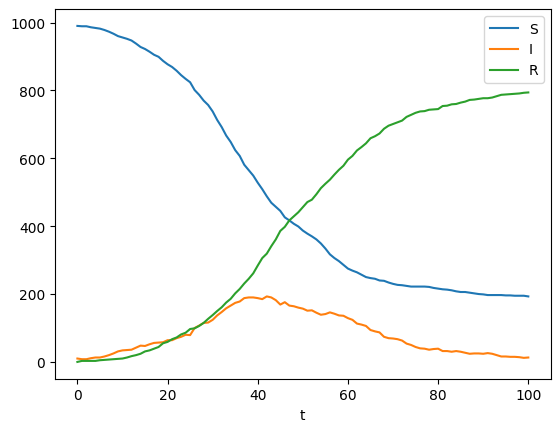

In [4]:
# Show a single plot line
single.plot("t", ["S", "I", "R"])


<Axes: xlabel='t'>

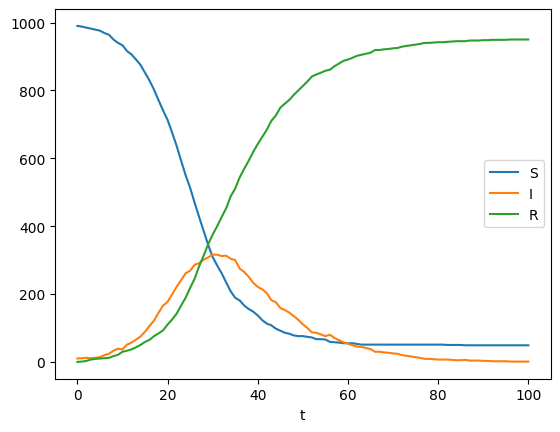

In [5]:
# We can also vary the parameters
alt = run_sir(beta = 0.3)
alt.plot("t", ["S", "I", "R"])

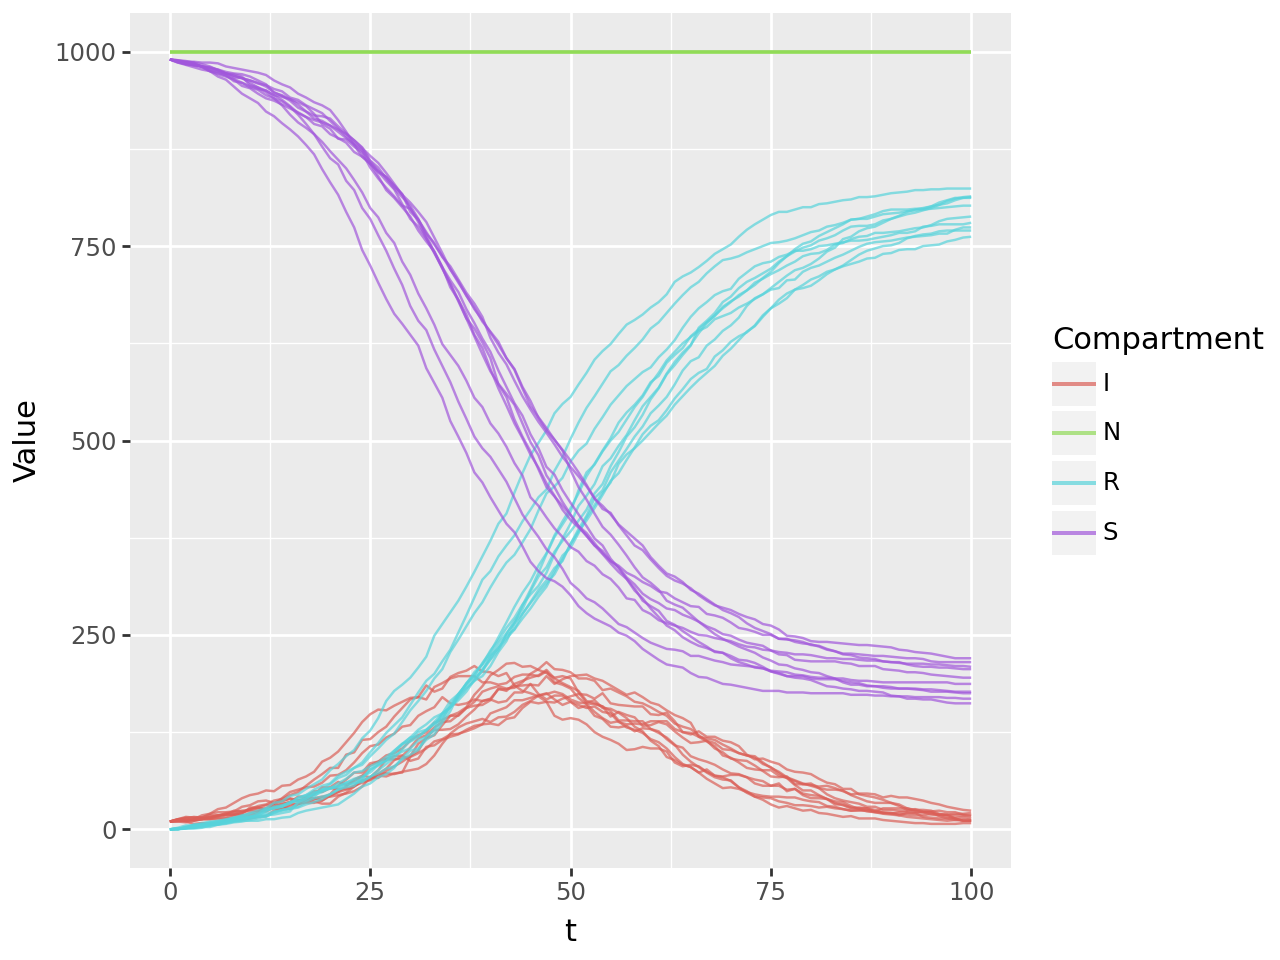

In [6]:
# we can run multiple realisations
reps = run_model_with_replicates(model = run_sir, reps = 10)

# and plot these
p = plot_model_outputs(reps)

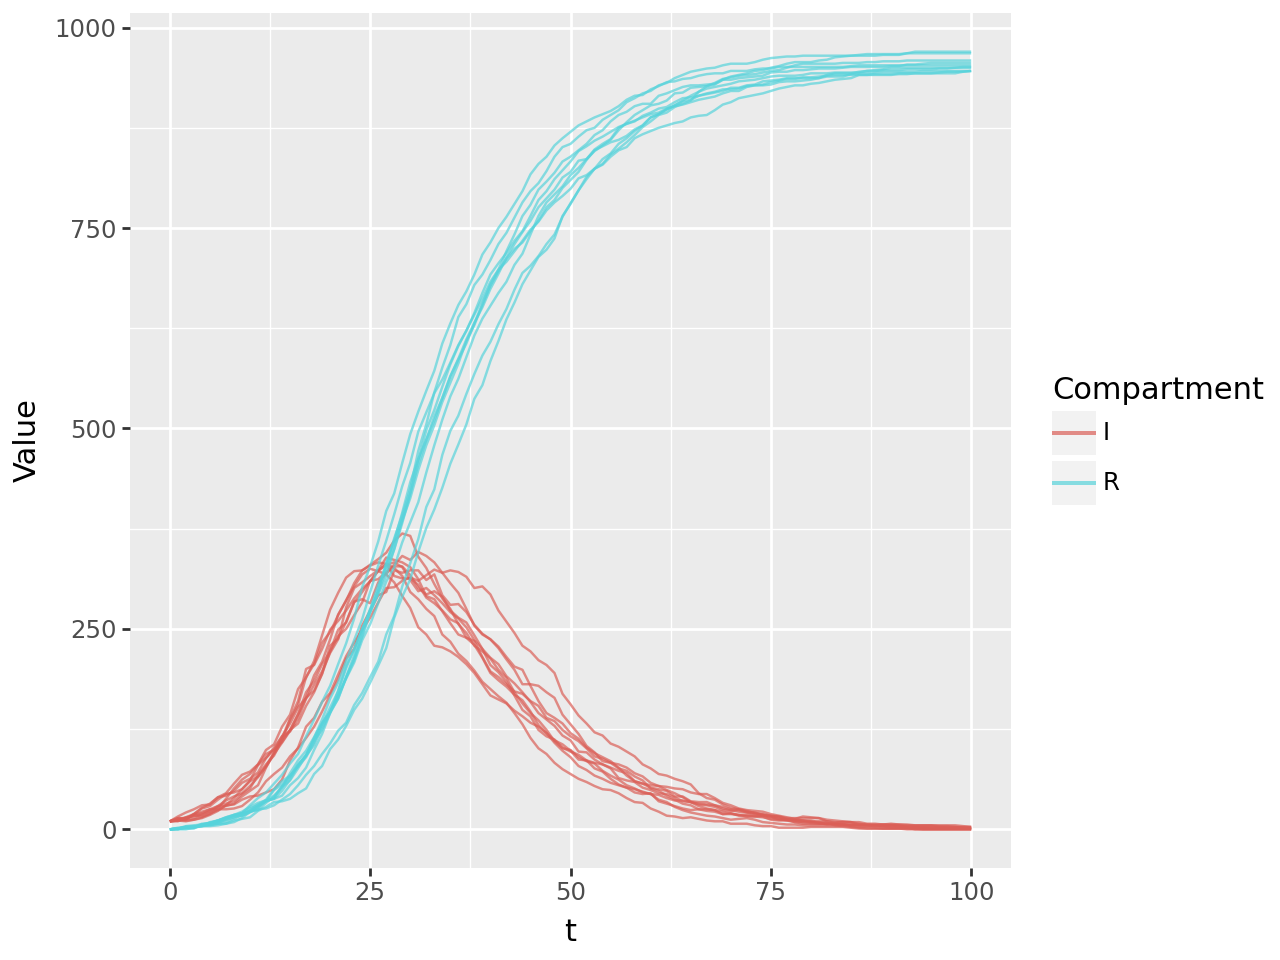

In [7]:
# we can also by args to run_sir through kwargs
reps = run_model_with_replicates(model=run_sir, reps=10, beta = 0.3)

# and plot these
p = plot_model_outputs(reps, columns = ["I", "R"])

In [8]:
# now to generate a lhs sample
param_ranges = {"beta": [0.1, 0.5], "gamma": [0.05, 0.5]}
df_samples = generate_lhs_samples(param_ranges, n_samples=9, seed=42)
df_samples

,beta,gamma
0,0.376713,0.228056
1,0.150729,0.165132
2,0.229148,0.351219
3,0.421727,0.310697
4,0.272084,0.127481
5,0.350187,0.253662
6,0.471384,0.458862
7,0.302515,0.088638
8,0.119796,0.446809


In [9]:
# Run the model for each row of samples:
results = [
    run_model_with_replicates(**row.to_dict(), reps=10).assign(**row.to_dict())
    for _, row in df_samples.iterrows()
]

# Combine results into one DataFrame:
df_all_results = pd.concat(results, axis=0)

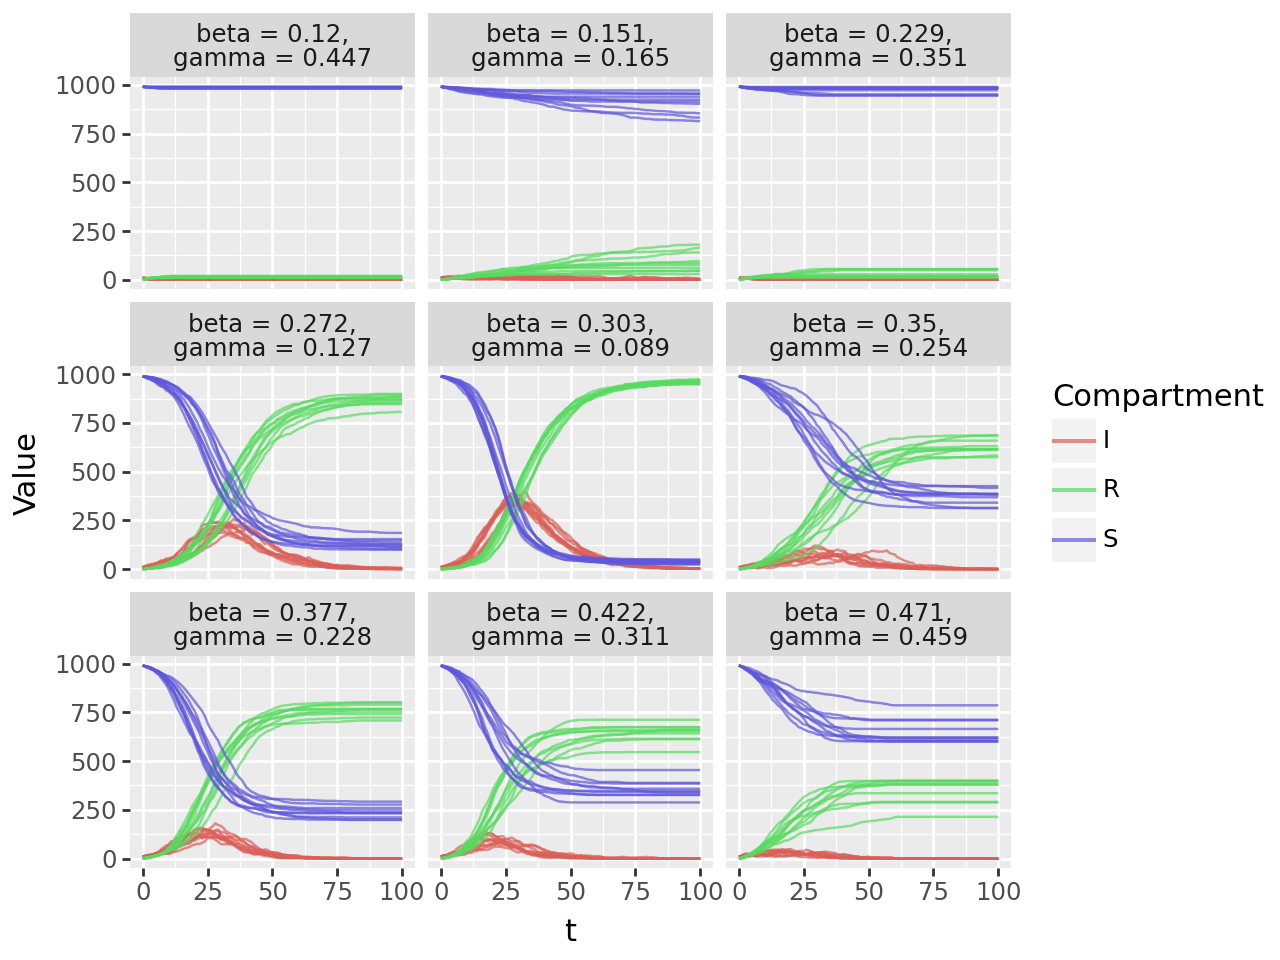

In [10]:
# Reshape dataframe into tidy long-format
df_long = df_all_results.melt(
    id_vars=["t", "replicate", "gamma", "beta"],
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long = df_long.assign(
    uid=df_long["Compartment"]
    + df_long["replicate"].astype(str)
)

# Add facet identifier for group plotting
df_long = df_long.assign(
    facet="beta = "
    + df_long["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long["gamma"].round(3).astype(str)
)

# Plot: color by compartment, lines grouped by replicate
p = (
    ggplot(
        df_long,
        aes(x="t", y="Value", group="uid", color="Compartment"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)

# Explicitly plot
ggplot.show(p)

In [22]:
# Import necessary libraries for neural networks
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import json

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for saving models and plots
output_dir = "emulator_results"
os.makedirs(output_dir, exist_ok=True)

# Generate LHS samples ensuring beta > gamma (R0 > 1)
# Instead of independent ranges, we'll sample R0 and recovery rate
n_samples = 10000
r0_range = [1.1, 4.0]  # Ensuring R0 > 1 for epidemics
gamma_range = [0.05, 0.25]  # Recovery rate

# Custom sampling to ensure beta > gamma
r0_samples = np.linspace(r0_range[0], r0_range[1], n_samples)
gamma_samples = np.linspace(gamma_range[0], gamma_range[1], n_samples)

np.random.shuffle(r0_samples)
np.random.shuffle(gamma_samples)

# Calculate beta = R0 * gamma
beta_samples = r0_samples * gamma_samples
param_df = pd.DataFrame({
    'beta': beta_samples,
    'gamma': gamma_samples,
    'R0': r0_samples
})

print(f"Generated {len(param_df)} parameter sets with R0 ranging from {param_df['R0'].min():.2f} to {param_df['R0'].max():.2f}")

# Run the SIR model for each parameter set
print("Generating training data...")
results = []
for _, row in tqdm(param_df.iterrows(), total=len(param_df)):
    # Use only beta and gamma for model running
    model_params = {'beta': row['beta'], 'gamma': row['gamma']}
    sim_result = run_sir(**model_params)
    # Add the parameters to the result dataframe
    sim_result = sim_result.assign(**model_params)
    results.append(sim_result)

# Combine results into one DataFrame
df_all_results = pd.concat(results, axis=0)

Generated 10000 parameter sets with R0 ranging from 1.10 to 4.00
Generating training data...


  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
class SIRTimeSeriesDataset(Dataset):
    def __init__(self, dataframe, lookback=10, features=['beta', 'gamma'], targets=['S', 'I']):
        self.lookback = lookback
        self.features = features
        self.targets = targets

        # Group by parameter sets
        self.grouped = dataframe.groupby(['beta', 'gamma'])
        self.param_sets = list(self.grouped.groups.keys())

        # Extract timepoints (assuming they're the same for all parameter sets)
        self.timepoints = dataframe['t'].unique()
        self.time_length = len(self.timepoints)

        # Create samples
        self.samples = []
        for param_set in self.param_sets:
            df_group = self.grouped.get_group(param_set).sort_values('t')

            # Extract feature and target time series
            feature_values = np.array([param_set[features.index('beta')],
                                      param_set[features.index('gamma')]])

            # Extract full target time series
            target_series = np.column_stack([df_group[target].values for target in targets])

            # Store full time series with parameter info
            self.samples.append({
                'features': feature_values,
                'targets': target_series,
                'param_values': param_set
            })

        # Normalize input features
        feature_array = np.array([s['features'] for s in self.samples])
        self.feature_scaler = StandardScaler()
        self.feature_scaler.fit(feature_array)

        # No need to normalize S and I as they're already in [0,1] range

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Normalize features
        features_normalized = self.feature_scaler.transform(sample['features'].reshape(1, -1)).flatten()

        return torch.tensor(features_normalized, dtype=torch.float32), \
               torch.tensor(sample['targets'], dtype=torch.float32)

In [24]:
# Create dataset
sir_dataset = SIRTimeSeriesDataset(df_all_results, lookback=10)

# Split into train, validation, and test sets (70%, 15%, 15%)
total_size = len(sir_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Create indices for the split
indices = list(range(total_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# Create subset datasets
from torch.utils.data import Subset
train_dataset = Subset(sir_dataset, train_indices)
val_dataset = Subset(sir_dataset, val_indices)
test_dataset = Subset(sir_dataset, test_indices)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Dataset created with {total_size} parameter sets")
print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")

Dataset created with 10000 parameter sets
Train: 7000, Validation: 1500, Test: 1500


In [25]:
# Define constants
input_size = 2  # beta and gamma
hidden_size = 64
output_size = 2  # S and I
num_layers = 2
dropout_prob = 0.1

# Feedforward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps, output_channels):
        super(FFNN, self).__init__()
        self.time_steps = time_steps
        self.output_channels = output_channels

        # Deeper network with dropout and batch normalization
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size, hidden_size*2),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size*2, hidden_size*2),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_size*2, time_steps * output_channels)
        )

    def forward(self, x):
        # Output shape: [batch_size, time_steps, output_channels]
        output = self.network(x)
        return output.view(-1, self.time_steps, self.output_channels)

# GRU Model (similar to the reference script)
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, num_layers=2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Project parameters to a sequence
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # GRU layer
        self.gru = nn.GRU(
            hidden_size, hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True
        )

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        batch_size = x.size(0)
        time_steps = sir_dataset.time_length

        # Create a sequence from the parameter input
        x_seq = self.input_projection(x).unsqueeze(1).repeat(1, time_steps, 1)

        # Process with GRU
        out, _ = self.gru(x_seq)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# LSTM Model (similar to the reference script)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Project parameters to a sequence
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            hidden_size, hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0.0,
            batch_first=True
        )

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        batch_size = x.size(0)
        time_steps = sir_dataset.time_length

        # Create a sequence from the parameter input
        x_seq = self.input_projection(x).unsqueeze(1).repeat(1, time_steps, 1)

        # Process with LSTM
        out, _ = self.lstm(x_seq)
        out = self.ln(out)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# Initialize models
ffnn_model = FFNN(input_size, hidden_size, sir_dataset.time_length, output_size)
gru_model = GRUModel(input_size, hidden_size, output_size, dropout_prob, num_layers)
lstm_model = LSTMModel(input_size, hidden_size, output_size, dropout_prob, num_layers)

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ffnn_model = ffnn_model.to(device)
gru_model = gru_model.to(device)
lstm_model = lstm_model.to(device)

print(f"Models initialized and moved to {device}")

Models initialized and moved to cuda


In [26]:
def train_model(model, train_loader, val_loader, epochs, lr, model_name, device, patience=10):
    # Initialize criterion, optimizer and scheduler
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # For tracking loss and best model
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    # Path to save best model
    best_model_path = os.path.join(output_dir, f"{model_name}_best.pt")

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * inputs.size(0)

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, targets)
                total_val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Update scheduler
        scheduler.step(avg_val_loss)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, {model_name} - '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'train_loss': avg_train_loss
            }, best_model_path)

            print(f"New best model saved at epoch {epoch} with validation loss: {avg_val_loss:.6f}")
        else:
            patience_counter += 1
            if epoch % 10 == 0:
                print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs. Best was epoch {best_epoch}.")
            break

    # Save training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'epochs': list(range(1, len(train_losses) + 1)),
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss
    }

    with open(os.path.join(output_dir, f"{model_name}_history.json"), 'w') as f:
        json.dump(history, f)

    # Load the best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history

# Set training parameters
learning_rate = 1e-3
num_epochs = 100
patience = 10

print("Training FFNN model...")
ffnn_model, ffnn_history = train_model(
    ffnn_model, train_loader, val_loader, num_epochs, learning_rate, "ffnn", device, patience
)

print("Training GRU model...")
gru_model, gru_history = train_model(
    gru_model, train_loader, val_loader, num_epochs, learning_rate, "gru", device, patience
)

print("Training LSTM model...")
lstm_model, lstm_history = train_model(
    lstm_model, train_loader, val_loader, num_epochs, learning_rate, "lstm", device, patience
)

Training FFNN model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 104436.124500
New best model saved at epoch 2 with validation loss: 63459.911510
New best model saved at epoch 3 with validation loss: 41432.730646
New best model saved at epoch 4 with validation loss: 25967.092187
New best model saved at epoch 5 with validation loss: 16857.213023
New best model saved at epoch 6 with validation loss: 9870.962557
New best model saved at epoch 7 with validation loss: 7327.849095
New best model saved at epoch 8 with validation loss: 5636.023039
New best model saved at epoch 9 with validation loss: 5410.085361
Epoch 10/100, ffnn - Train Loss: 6868.9444, Val Loss: 3887.4719
New best model saved at epoch 10 with validation loss: 3887.471922
New best model saved at epoch 11 with validation loss: 3554.377452
New best model saved at epoch 14 with validation loss: 3372.922528
New best model saved at epoch 16 with validation loss: 3143.850318
Epoch 20/100, ffnn - Train Loss: 6184.6946, Val Loss: 3802.9535
Vali

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 111350.236104
New best model saved at epoch 2 with validation loss: 70772.084188
New best model saved at epoch 3 with validation loss: 35857.628099
New best model saved at epoch 4 with validation loss: 14864.736435
New best model saved at epoch 5 with validation loss: 5942.902559
New best model saved at epoch 6 with validation loss: 3473.368871
New best model saved at epoch 7 with validation loss: 2320.014732
New best model saved at epoch 8 with validation loss: 2081.881875
New best model saved at epoch 9 with validation loss: 2071.360914
Epoch 10/100, gru - Train Loss: 2235.9091, Val Loss: 1888.1403
New best model saved at epoch 10 with validation loss: 1888.140310
New best model saved at epoch 13 with validation loss: 1845.682044
New best model saved at epoch 17 with validation loss: 1819.563156
Epoch 20/100, gru - Train Loss: 2126.5699, Val Loss: 1857.9604
Validation loss did not improve. Patience: 3/10
New best model saved at ep

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


New best model saved at epoch 1 with validation loss: 111578.491063
New best model saved at epoch 2 with validation loss: 70829.550708
New best model saved at epoch 3 with validation loss: 35713.970964
New best model saved at epoch 4 with validation loss: 14948.452602
New best model saved at epoch 5 with validation loss: 5996.943010
New best model saved at epoch 6 with validation loss: 3388.910350
New best model saved at epoch 7 with validation loss: 2425.883303
New best model saved at epoch 8 with validation loss: 2033.618235
New best model saved at epoch 9 with validation loss: 1913.241896
Epoch 10/100, lstm - Train Loss: 2227.6538, Val Loss: 2169.9325
Validation loss did not improve. Patience: 1/10
New best model saved at epoch 14 with validation loss: 1906.277953
New best model saved at epoch 15 with validation loss: 1843.907508
Epoch 20/100, lstm - Train Loss: 2042.4460, Val Loss: 1905.7540
Validation loss did not improve. Patience: 5/10
New best model saved at epoch 24 with valid

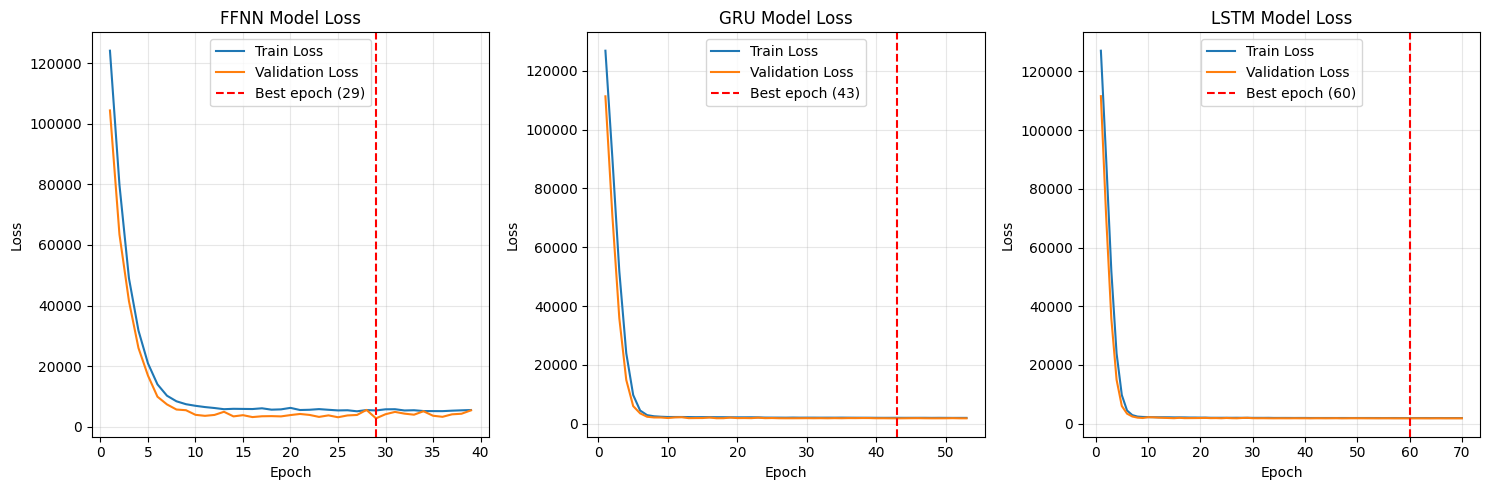

In [27]:
plt.figure(figsize=(15, 5))

# Plot FFNN losses
plt.subplot(1, 3, 1)
plt.plot(ffnn_history['epochs'], ffnn_history['train_loss'], label='Train Loss')
plt.plot(ffnn_history['epochs'], ffnn_history['val_loss'], label='Validation Loss')
plt.axvline(x=ffnn_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({ffnn_history['best_epoch']})")
plt.title('FFNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot GRU losses
plt.subplot(1, 3, 2)
plt.plot(gru_history['epochs'], gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['epochs'], gru_history['val_loss'], label='Validation Loss')
plt.axvline(x=gru_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({gru_history['best_epoch']})")
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot LSTM losses
plt.subplot(1, 3, 3)
plt.plot(lstm_history['epochs'], lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['epochs'], lstm_history['val_loss'], label='Validation Loss')
plt.axvline(x=lstm_history['best_epoch'], color='r', linestyle='--',
            label=f"Best epoch ({lstm_history['best_epoch']})")
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "training_history.png"))
plt.show()

Generating predictions...


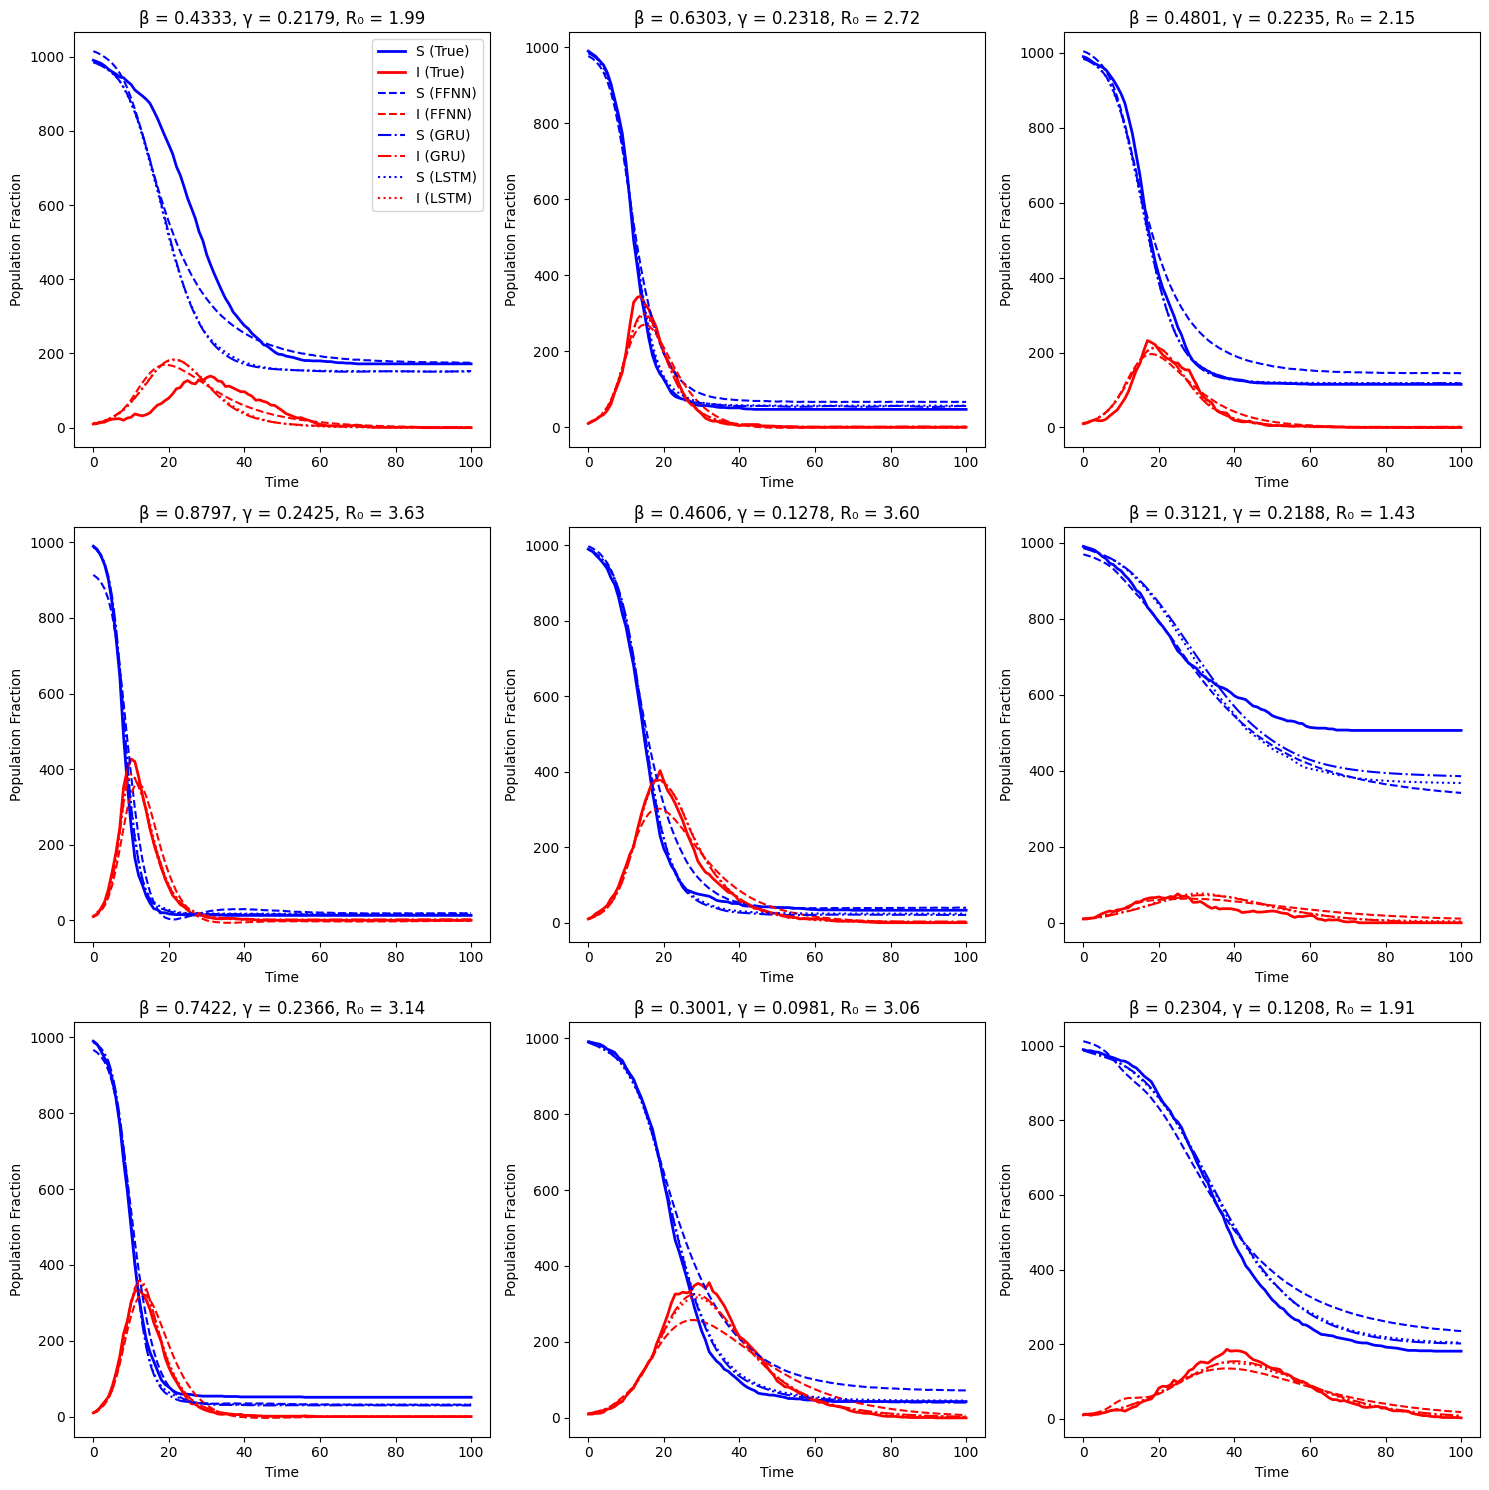

In [28]:
# Function to make predictions
def predict_with_model(model, dataset, device):
    model.eval()
    predictions = []
    targets = []
    param_values = []

    with torch.no_grad():
        for idx in range(len(dataset)):
            inputs, target = dataset.dataset[dataset.indices[idx]]

            # Get original parameters
            param_vals = sir_dataset.samples[dataset.indices[idx]]['param_values']
            param_values.append(param_vals)

            # Make prediction
            inputs = inputs.unsqueeze(0).to(device)
            output = model(inputs).squeeze(0).cpu().numpy()

            # Store results
            predictions.append(output)
            targets.append(target.numpy())

    return predictions, targets, param_values

# Make predictions on validation set
print("Generating predictions...")
ffnn_preds, ffnn_targets, ffnn_params = predict_with_model(ffnn_model, val_dataset, device)
gru_preds, gru_targets, gru_params = predict_with_model(gru_model, val_dataset, device)
lstm_preds, lstm_targets, lstm_params = predict_with_model(lstm_model, val_dataset, device)

# Create validation visualization plot (3x3 grid)
plt.figure(figsize=(15, 15))

# Select 9 examples to plot
num_plots = min(9, len(val_dataset))
indices = np.linspace(0, len(val_dataset)-1, num_plots, dtype=int)

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)

    beta, gamma = ffnn_params[idx]
    timepoints = sir_dataset.timepoints

    # Plot ground truth
    plt.plot(timepoints, ffnn_targets[idx][:, 0], 'b-', label='S (True)', linewidth=2)
    plt.plot(timepoints, ffnn_targets[idx][:, 1], 'r-', label='I (True)', linewidth=2)

    # Plot model predictions with different line styles
    plt.plot(timepoints, ffnn_preds[idx][:, 0], 'b--', label='S (FFNN)')
    plt.plot(timepoints, ffnn_preds[idx][:, 1], 'r--', label='I (FFNN)')

    plt.plot(timepoints, gru_preds[idx][:, 0], 'b-.', label='S (GRU)')
    plt.plot(timepoints, gru_preds[idx][:, 1], 'r-.', label='I (GRU)')

    plt.plot(timepoints, lstm_preds[idx][:, 0], 'b:', label='S (LSTM)')
    plt.plot(timepoints, lstm_preds[idx][:, 1], 'r:', label='I (LSTM)')

    # Add title with parameter values
    plt.title(f'β = {beta:.4f}, γ = {gamma:.4f}, R₀ = {beta/gamma:.2f}')

    # Add axis labels and legend (only for first plot to avoid clutter)
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')
    if i == 0:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "validation_predictions.png"))
plt.show()